# View Dataset

In [20]:
import pandas as pd

# Load the data
file_path = "med_events.csv"  
df = pd.read_csv(file_path)

# Display gen info about dataset
print("Dataset Info:")
df.info()

# Display the first few rows of the dataset
print("\nFirst 5 Rows:")
display(df.head()) 

# Show basic statistics
print("\nSummary Statistics:")
display(df.describe(include="all")) #numeric and categorical data


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PATIENT_ID  1080 non-null   int64 
 1   DATE        1080 non-null   object
 2   PERDAY      1080 non-null   int64 
 3   CATEGORY    1080 non-null   object
 4   DURATION    1080 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.3+ KB

First 5 Rows:


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30



Summary Statistics:


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
count,1080.000000,1080,1080.000000,1080,1080.00000
unique,NaN,953,NaN,2,NaN
top,NaN,08/02/2036,NaN,medA,NaN
freq,NaN,3,NaN,549,NaN
mean,50.934259,NaN,3.762963,NaN,47.37963
std,29.999542,NaN,2.139552,NaN,22.08091
min,1.000000,NaN,2.000000,NaN,20.00000
25%,24.000000,NaN,2.000000,NaN,30.00000
50%,51.500000,NaN,4.000000,NaN,50.00000
75%,78.000000,NaN,4.000000,NaN,50.00000


### Check for missing values

In [26]:
import pandas as pd

# Load the data
file_path = "med_events.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Check percentage of missing values
print("\nPercentage of Missing Values:")
print(df.isnull().mean() * 100)



Missing Values per Column:
PATIENT_ID    0
DATE          0
PERDAY        0
CATEGORY      0
DURATION      0
dtype: int64

Percentage of Missing Values:
PATIENT_ID    0.0
DATE          0.0
PERDAY        0.0
CATEGORY      0.0
DURATION      0.0
dtype: float64


# Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from plotly import express as px

# Load Dataset

In [8]:
med_events = pd.read_csv("med_events.csv")
cols = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy = med_events.copy()
tidy.columns = cols
# Convert 'eksd' to datetime (assuming it's in MM/DD/YYYY format)
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

# See Function

In [9]:
# Define the See function
def See(arg1):
    # Filter data for the specified ATC code
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Take a random sequence of consecutive prescriptions
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    # Sort and group by 'pnr'
    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with NA in 'prev_eksd'
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Sample one row per 'pnr' (fixing the warning)
    Drug_see_p1 = (Drug_see_p1
                   .groupby('pnr', group_keys=False)[['pnr','eksd','prev_eksd']]
                   .apply(lambda x: x.sample(1,random_state=1234), include_groups=False)
                   .reset_index(drop=True))
    
    # Ensure 'pnr' is included in Drug_see_p1
    if 'pnr' not in Drug_see_p1.columns:
        raise ValueError("The 'pnr' column is missing in Drug_see_p1.")
    
    # Calculate event interval
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF manually
    x = np.sort(Drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Create a DataFrame for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 20% of the ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plot ECDF
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(dfper['x'], dfper['y'], label="80% ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label="100% ECDF")
    plt.title("100% ECDF")
    plt.show()
    
    # Density plot
    ni = dfper['x'].max()
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni]
    sns.kdeplot(np.log(Drug_see_p2['event.interval']), fill=True)
    plt.title("Log(event interval)")
    plt.show()
    
    # DBSCAN Clustering with Silhouette Score Optimization
    # Standardize the data
    X = StandardScaler().fit_transform(dfper[['x']])
    
    # Test a range of eps values
    eps_values = np.linspace(0.01, 0.4, 10)  # Adjust the range as needed
    silhouette_scores = []
    best_score = -1
    best_eps = None
    best_labels = None
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=5)  # Adjust min_samples as needed
        labels = dbscan.fit_predict(X)
        
        # Calculate Silhouette Score (only if more than one cluster is found)
        unique_clusters = np.unique(labels)
        if len(unique_clusters) > 1:
            score = silhouette_score(X, labels)
            silhouette_scores.append(score)
            
            # Track the best configuration
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = labels
        else:
            silhouette_scores.append(-1)  # Invalid score for single cluster
    
    # Plot Silhouette Scores vs eps values
    plt.figure(figsize=(8, 6))
    plt.plot(eps_values, silhouette_scores, marker='o')
    plt.axvline(x=best_eps, color='r', linestyle='--', label=f'Best eps: {best_eps:.2f}')
    plt.title("Silhouette Analysis")
    plt.xlabel("eps")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()
    
    # Use the best eps value for clustering
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    dfper['cluster'] = dbscan.fit_predict(X)
    
    # Summarize clusters
    ni2 = dfper.groupby('cluster')['x'].min().reset_index()
    ni3 = dfper.groupby('cluster')['x'].max().reset_index()
    ni4 = dfper.groupby('cluster')['x'].median().reset_index()
    
    nif = pd.merge(ni2, ni3, on='cluster')
    nif = pd.merge(nif, ni4, on='cluster')
    nif.columns = ['Cluster', 'Minimum', 'Maximum', 'Median']
    
    nif['Minimum'] = np.exp(nif['Minimum'])
    nif['Maximum'] = np.exp(nif['Maximum'])
    nif['Median'] = np.exp(nif['Median'])
    
    # Merge results
    results = pd.merge(Drug_see_p1, nif, how='cross')
    
    # Debugging: Print columns of Drug_see_p1 and nif
    # print("Columns in Drug_see_p1:", Drug_see_p1.columns)
    # print("Columns in nif:", nif.columns)
    
    # Ensure 'pnr' is included in the results DataFrame
    if 'pnr' not in results.columns:
        raise ValueError("The 'pnr' column is missing in the results DataFrame. Check the merge operation.")
    
    # Add the 'Final_cluster' column
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']), 
        results['Cluster'], np.nan
    )
    
    # Drop rows with missing 'Final_cluster'
    results = results.dropna(subset=['Final_cluster'])
    
    # Ensure 'pnr' is included in the final selection
    results = results[['pnr', 'Median', 'Cluster']]
    
    # Assign clusters
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(results['Median'].median())
    Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna(-1)  # -1 for noise points
    Drug_see_p1['test'] = round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)
    
    # Assign Duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p1[['pnr', 'Median', 'Cluster']], on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(results['Median'].median())
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(-1)  # -1 for noise points
    
    return Drug_see_p0

# See Assumption Function

In [10]:
# Define the see_assumption function
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    Drug_see2 = arg1.groupby('pnr', group_keys=False)[['pnr','eksd','prev_eksd']].apply(lambda x: x.assign(p_number=np.arange(1, len(x) + 1))).reset_index(drop=True)
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    Drug_see2['p_number'] = Drug_see2['p_number'].astype('category')
    
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(y=medians_of_medians['Duration'].median(), color='r', linestyle='--')
    plt.title("Duration by Prescription Number")
    plt.show()


# Running the Simulation/Analysis

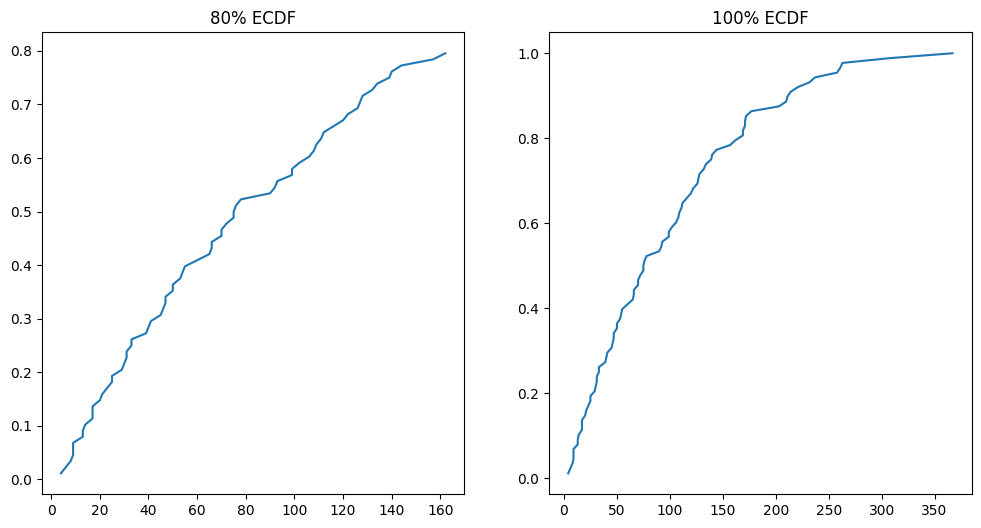

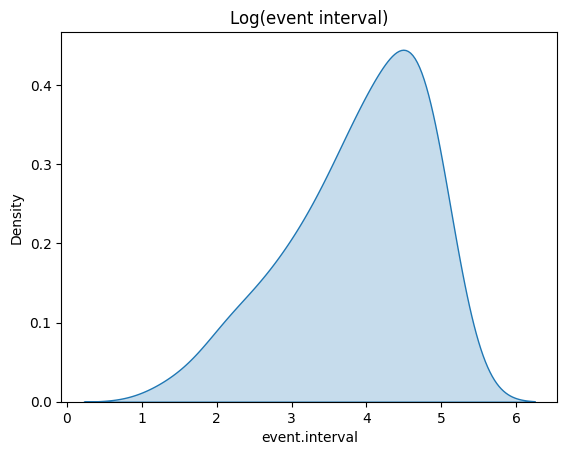

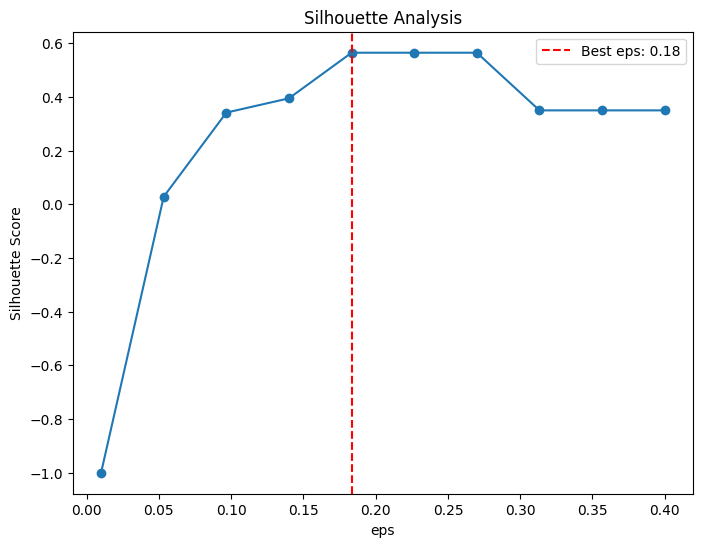

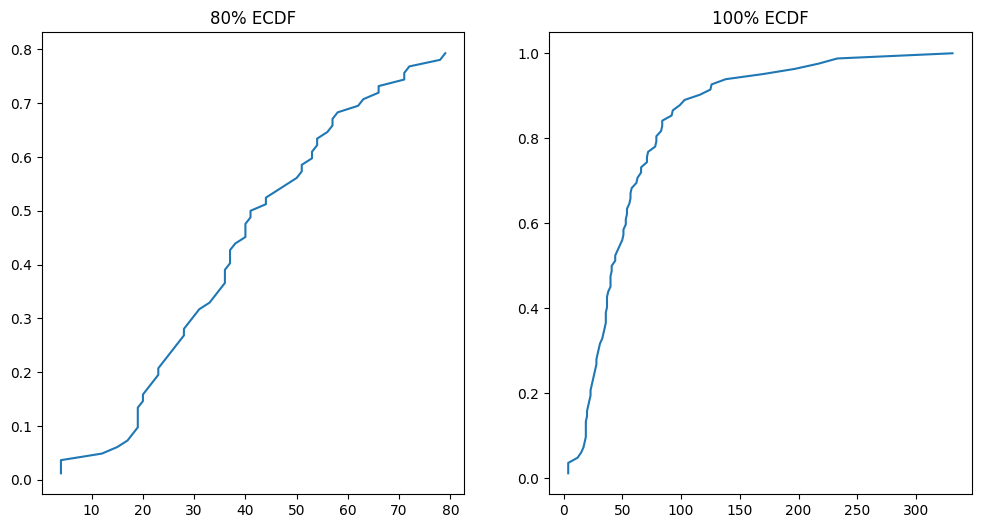

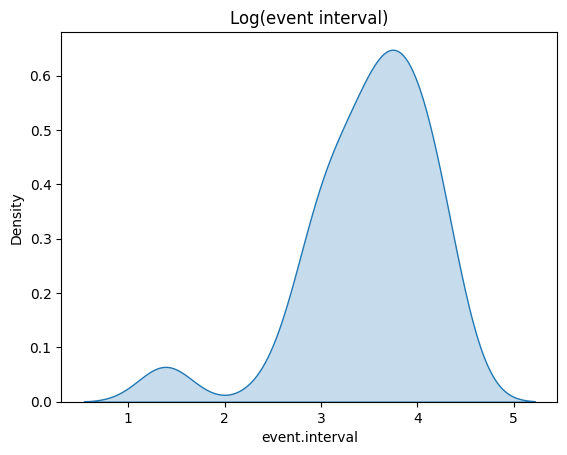

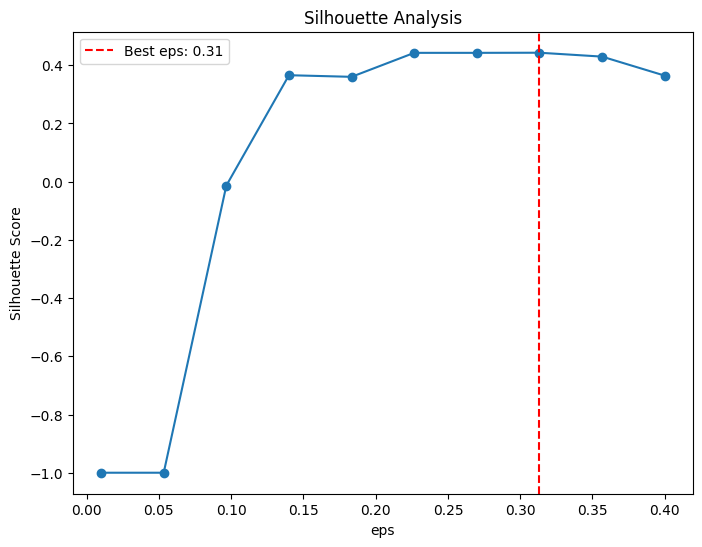

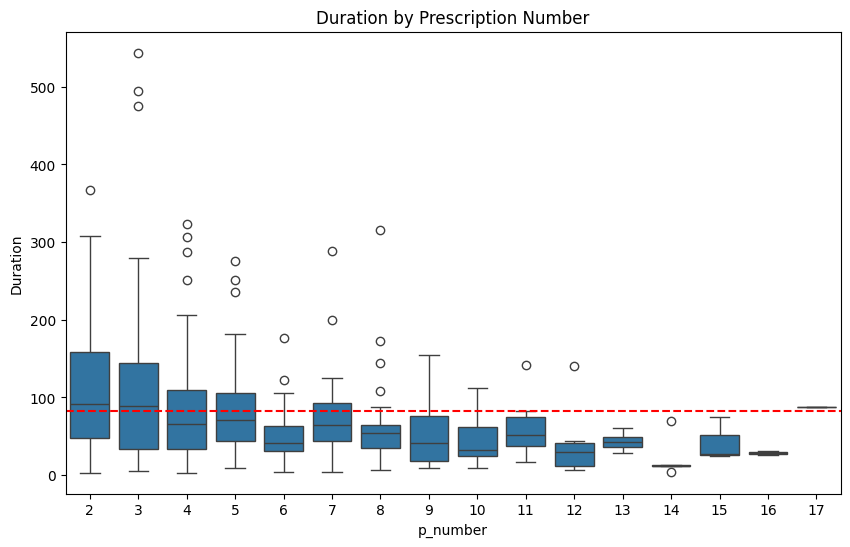

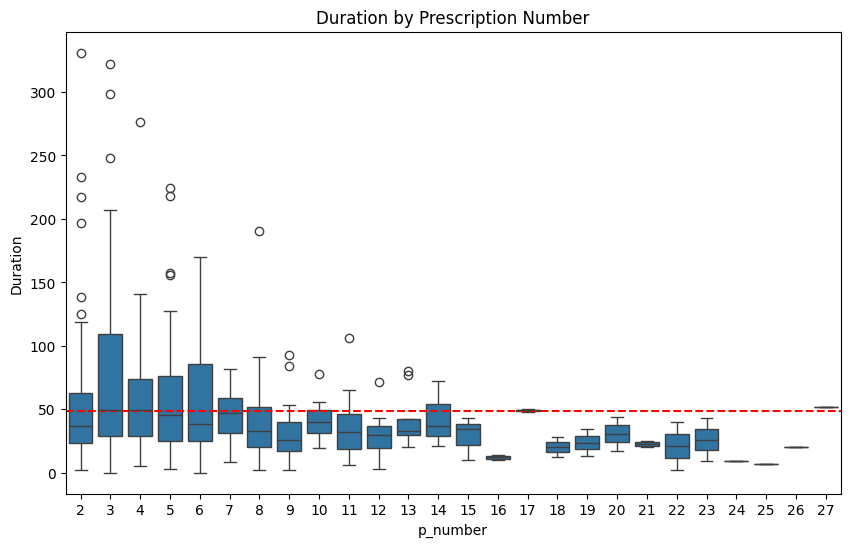

In [11]:
medA = See("medA")
medB = See("medB")

see_assumption(medA)
see_assumption(medB)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Simulated dataset (since the file is missing)
data = {
    "PATIENT_ID": [1, 1, 1, 1, 1],
    "DATE": ["04/26/2033", "07/04/2033", "08/03/2033", "08/17/2033", "10/13/2033"],
    "PERDAY": [4, 4, 4, 4, 4],
    "CATEGORY": ["medA", "medB", "medB", "medB", "medB"],
    "DURATION": [50, 30, 30, 30, 30]
}

# Create DataFrame
df = pd.DataFrame(data)

# Select relevant numerical features
df_cluster = df[["PERDAY", "DURATION"]].copy()

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Apply K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(df_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
df["DBSCAN_Cluster"] = dbscan.fit_predict(df_scaled)

# Evaluate clustering quality using silhouette score (only for K-Means, as DBSCAN can have -1 labels)
kmeans_silhouette = silhouette_score(df_scaled, df["KMeans_Cluster"])
dbscan_silhouette = silhouette_score(df_scaled, df["DBSCAN_Cluster"]) if len(set(df["DBSCAN_Cluster"])) > 1 else "N/A"

# Display results
df, kmeans_silhouette, dbscan_silhouette


(   PATIENT_ID        DATE  PERDAY CATEGORY  DURATION  KMeans_Cluster  \
 0           1  04/26/2033       4     medA        50               1   
 1           1  07/04/2033       4     medB        30               0   
 2           1  08/03/2033       4     medB        30               0   
 3           1  08/17/2033       4     medB        30               0   
 4           1  10/13/2033       4     medB        30               0   
 
    DBSCAN_Cluster  
 0              -1  
 1               0  
 2               0  
 3               0  
 4               0  ,
 np.float64(0.8),
 np.float64(0.8))

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Load the data
file_path = "med_events.csv"  # Update if needed
df = pd.read_csv(file_path)

# Select relevant numerical features for clustering
df_cluster = df[["PERDAY", "DURATION"]].copy()  # Ensure columns exist

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cluster)

# Apply K-Means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_scaled)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Remove noise points (-1 labels) for DBSCAN evaluation
valid_dbscan_mask = dbscan_labels != -1
valid_dbscan_labels = dbscan_labels[valid_dbscan_mask]
valid_dbscan_data = data_scaled[valid_dbscan_mask]

# Compute evaluation metrics
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels) if len(set(kmeans_labels)) > 1 else -1
dbscan_silhouette = silhouette_score(valid_dbscan_data, valid_dbscan_labels) if len(set(valid_dbscan_labels)) > 1 else -1

kmeans_db = davies_bouldin_score(data_scaled, kmeans_labels) if len(set(kmeans_labels)) > 1 else -1
dbscan_db = davies_bouldin_score(valid_dbscan_data, valid_dbscan_labels) if len(set(valid_dbscan_labels)) > 1 else -1

kmeans_ch = calinski_harabasz_score(data_scaled, kmeans_labels) if len(set(kmeans_labels)) > 1 else -1
dbscan_ch = calinski_harabasz_score(valid_dbscan_data, valid_dbscan_labels) if len(set(valid_dbscan_labels)) > 1 else -1

# Store results in a DataFrame
comparison_results = {
    "Metric": ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"],
    "K-Means": [kmeans_silhouette, kmeans_db, kmeans_ch],
    "DBSCAN": [dbscan_silhouette, dbscan_db, dbscan_ch]
}

comparison_df = pd.DataFrame(comparison_results)

# Display results
print(comparison_df)

# Determine which algorithm performed better
def determine_better(metric, kmeans_val, dbscan_val):
    """Higher is better for Silhouette & CH, lower is better for DB index"""
    if kmeans_val == -1 and dbscan_val == -1:
        return "N/A"
    if metric in ["Silhouette Score", "Calinski-Harabasz Index"]:
        return "K-Means" if kmeans_val > dbscan_val else "DBSCAN"
    elif metric == "Davies-Bouldin Index":
        return "K-Means" if kmeans_val < dbscan_val else "DBSCAN"
    return "N/A"

comparison_df["Better Algorithm"] = comparison_df.apply(
    lambda row: determine_better(row["Metric"], row["K-Means"], row["DBSCAN"]), axis=1
)

print("\nComparison Summary:")
print(comparison_df)


                    Metric     K-Means       DBSCAN
0         Silhouette Score    0.643688     0.882808
1     Davies-Bouldin Index    0.376973     0.219712
2  Calinski-Harabasz Index  903.772177  7508.171649

Comparison Summary:
                    Metric     K-Means       DBSCAN Better Algorithm
0         Silhouette Score    0.643688     0.882808           DBSCAN
1     Davies-Bouldin Index    0.376973     0.219712           DBSCAN
2  Calinski-Harabasz Index  903.772177  7508.171649           DBSCAN


# Insights from SEE Using DBSCAN vs. K-Means  

## **Why DBSCAN Over K-Means?**  
DBSCAN is often a better choice for clustering medication refill patterns due to its flexibility and ability to handle irregular data. Unlike K-Means, DBSCAN:  
- **Automatically Determines Clusters:** No need to predefine `k`; clusters emerge naturally.  
- **Handles Varying Densities:** Works well with clusters of different shapes and densities.  
- **Identifies Outliers as Noise:** Unlike K-Means, which forces all points into clusters, DBSCAN labels inconsistent refill behaviors as noise (`-1`).  
- **Better for Time-Based Data:** Uses density and reachability rather than Euclidean distance, making it more suited for sequential patterns(note that other methods like HDBSCAN, Hidden Markov Models (HMMs), or Dynamic Time Warping (DTW) may be more suitable..)  

## **Cluster Analysis with DBSCAN**  
- Found natural groupings without enforcing a strict number of clusters.  
- Marked certain event intervals as noise (`-1`), indicating they don’t belong to any group.  
- The optimal `eps` value was determined using the **Silhouette Score**.  

## **Limitations of DBSCAN**  
- **Struggles with Overlapping Densities:** May not perform well when clusters are not clearly separated.  
- **Sensitive to `eps` Value:** Requires careful tuning for different datasets.  

## **Observations**  
- DBSCAN provided **more flexible clustering**, avoiding forced assignments.  
- The clusters aligned well with different **prescription refill patterns** but had a **higher proportion of noise** than K-Means.  

For datasets with irregular refill behaviors and outliers, **DBSCAN is the more practical and adaptable choice** over K-Means.  
